<a href="https://colab.research.google.com/github/soheldatta17/Knee-Arthritis-Detection/blob/main/KneeArthritisDetectionMainSample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knee Arthritis Detection using CNN.



## 1. Dataset preparation.

#### 1.1. Download dataset from kaggle.

In [1]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d hafiznouman786/annotated-dataset-for-knee-arthritis-detection

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/annotated-dataset-for-knee-arthritis-detection
License(s): CC0-1.0
  0% 0.00/58.3M [00:00<?, ?B/s]
100% 58.3M/58.3M [00:00<00:00, 1.34GB/s]


In [3]:
!unzip -qq annotated-dataset-for-knee-arthritis-detection.zip

Commands above will create a folder with the following content:

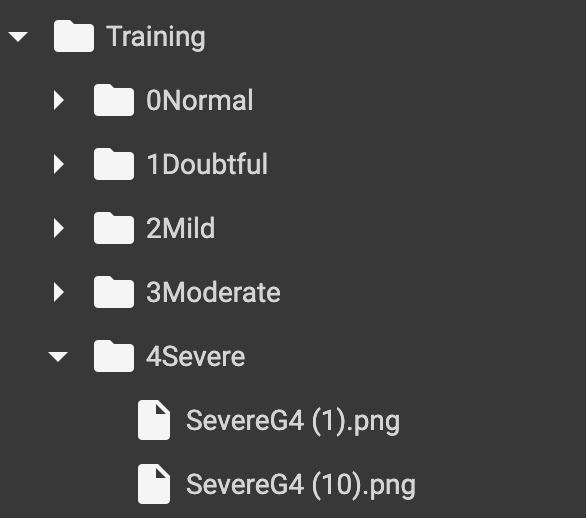

**Import all the necessary modules**

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import split_dataset
from tensorflow.keras import layers, backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# ============ Squeeze-and-Excitation (SE) Block for Channel Attention ============
def se_block(input_tensor, ratio=16):
    """Channel attention mechanism: learns to weight feature channels.
    Args:
        input_tensor: input feature map
        ratio: compression ratio for internal dimension (default 16)
    """
    filters = K.int_shape(input_tensor)[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)  # Squeeze spatial dims
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // ratio, activation="relu")(se)  # Compress
    se = layers.Dense(filters, activation="sigmoid")(se)  # Excitation
    return layers.Multiply()([input_tensor, se])  # Scale input channels
# =====================================================================

#### 1.2. Load dataset from the file system.

Found 1650 files belonging to 5 classes.


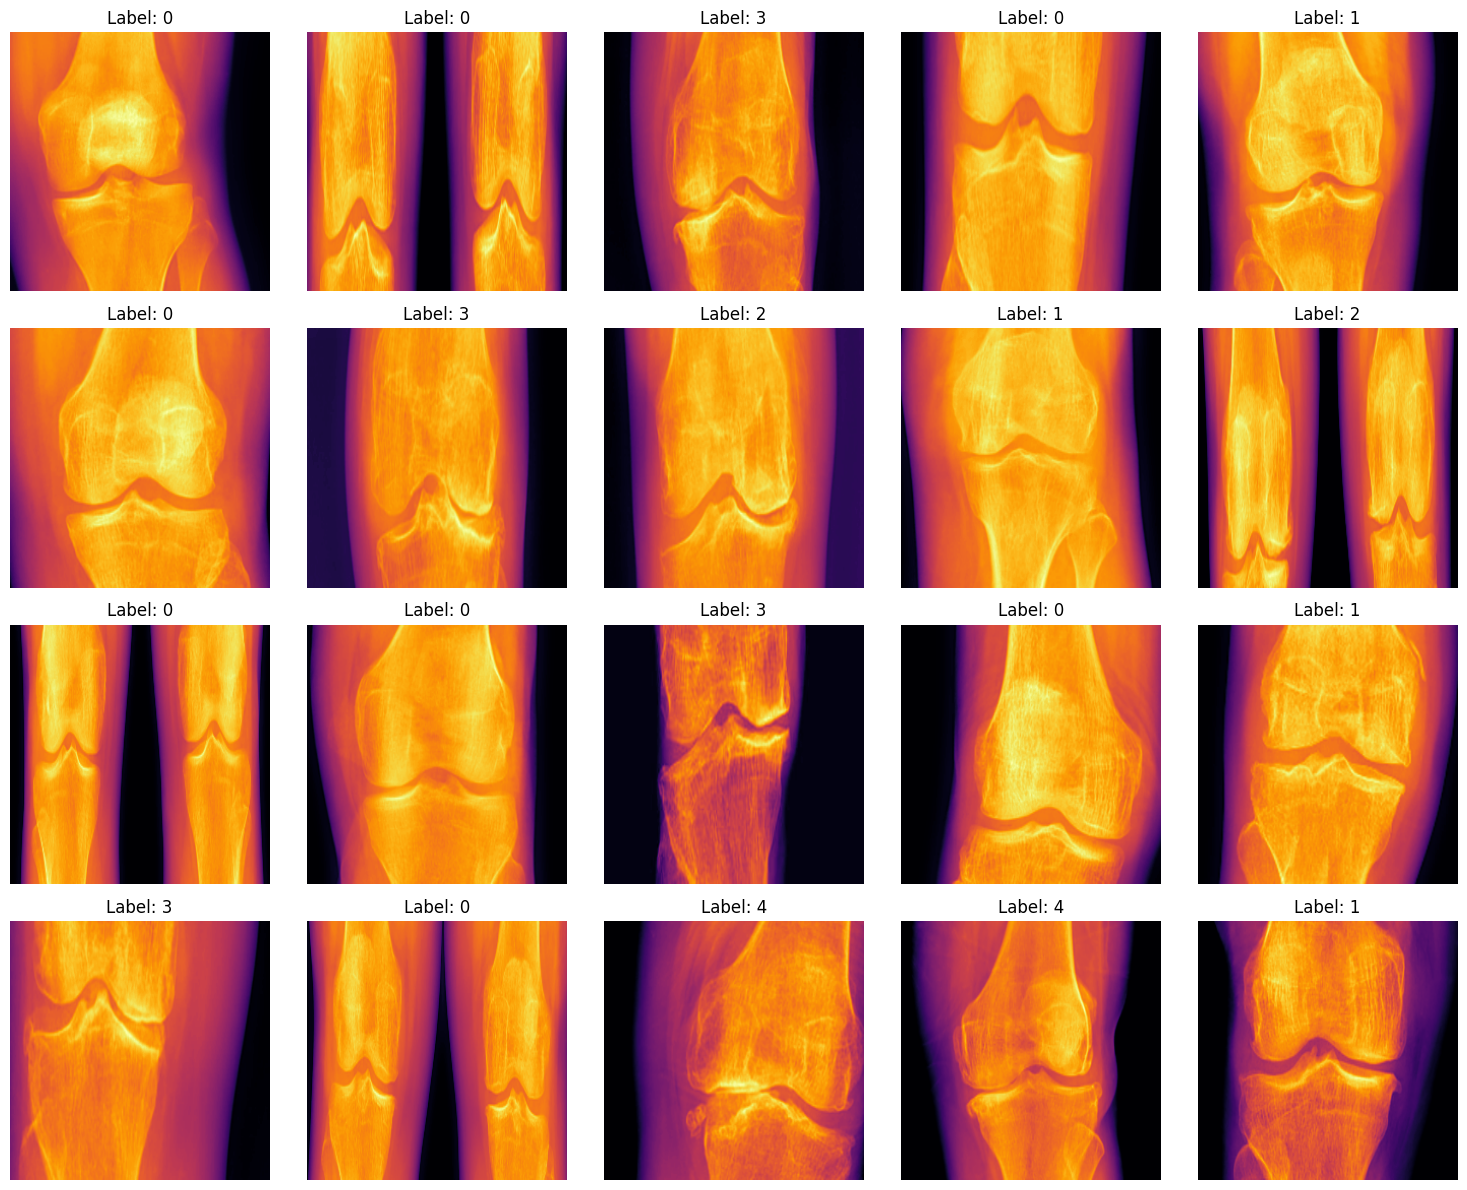

In [6]:
dataset = image_dataset_from_directory(
    "Training",
    color_mode="grayscale",
    image_size=(256, 256),
    batch_size=None,
)

# Take first 20 images without shuffling
dataset_preview = dataset.take(20)

# Plotting
plt.figure(figsize=(15, 12))

for i, (image, label) in enumerate(dataset_preview):
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.numpy().astype("uint8").squeeze(), cmap="inferno")
    plt.title(f"Label: {label.numpy().astype('uint8')}")
    plt.axis("off")

plt.tight_layout()
plt.show()

#### 1.3. Split dataset.

In [7]:
train_dataset, test_dataset = split_dataset(dataset, right_size=0.1)
train_dataset, val_dataset = split_dataset(train_dataset, right_size=0.1)

print("Train size:", train_dataset.cardinality().numpy())
print("Test size:", test_dataset.cardinality().numpy())
print("Validation size:", test_dataset.cardinality().numpy())

Train size: 1337
Test size: 165
Validation size: 165


## 2. Build the initial model architecture.


In [10]:
inputs = keras.Input(shape=(256, 256, 1))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

# Add SE attention block to learn channel importance
x = se_block(x, ratio=16)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 254, 254,  │        320 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 252, 252,  │      9,248 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 126, 126,  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 124, 124,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 122, 122,  │     36,928 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 61, 61,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 59, 59,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 57, 57,    │    147,584 │ conv2d_12[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 28, 28,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 26, 26,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 24, 24,    │    590,080 │ conv2d_14[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ conv2d_15[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 256) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 16)  │      4,112 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 256) │      4,352 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 24, 24,    │          0 │ conv2d_15[0][0],

 Total params: 1,917,429 (7.31 MB)

 Trainable params: 1,917,429 (7.31 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the model.

#### 3.1. Compile and launch training.

In [11]:
batched_train_dataset = train_dataset.batch(32)
batched_val_dataset = val_dataset.batch(32)

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    batched_train_dataset,
    epochs=20,
    validation_data=batched_val_dataset,
)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 54s 779ms/step - accuracy: 0.2906 - loss: 1.7291 - val_accuracy: 0.2703 - val_loss: 1.5618
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.2811 - loss: 1.5410 - val_accuracy: 0.2703 - val_loss: 1.5650
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.2822 - loss: 1.5421 - val_accuracy: 0.2703 - val_loss: 1.5640
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.2822 - loss: 1.5398 - val_accuracy: 0.3108 - val_loss: 1.5652
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.2745 - loss: 1.5405 - val_accuracy: 0.3311 - val_loss: 1.5353
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.3064 - loss: 1.5091 - val_accuracy: 0.3581 - val_loss: 1.5047
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.3313 - loss: 1.4954 - val_accuracy: 0.3446 - val_loss: 1.4939
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.3546 - loss: 1.4723 - val_accuracy: 0

In [12]:
def show_plots(history):
    accuracy = history["accuracy"]
    val_accuracy = history["val_accuracy"]
    loss = history["loss"]
    val_loss = history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "bo", label="Accuracy on the training step")
    plt.plot(epochs, val_accuracy, "b", label="Accuracy on the validation step")
    plt.title("Accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Loss on the training step")
    plt.plot(epochs, val_loss, "b", label="Loss on the validation step")
    plt.title("Loss")
    plt.legend()
    plt.show()

#### 3.2. Show results.

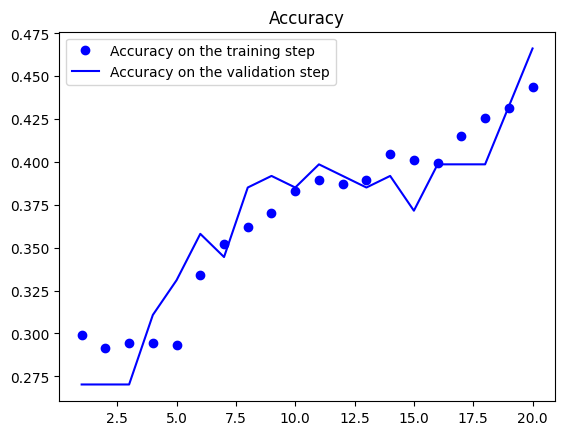

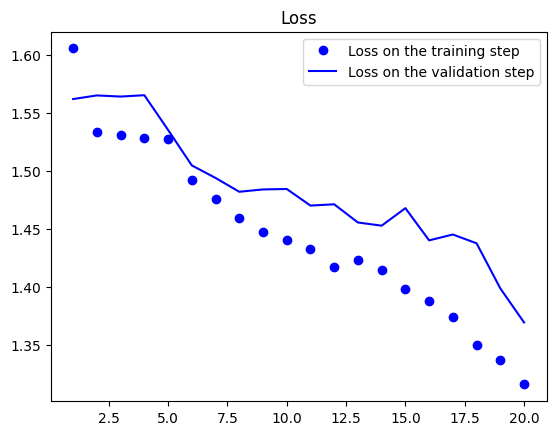

In [13]:
show_plots(history.history)

## 4. Adjust the model architecture.

#### 4.1. Applying the data augmentation.

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


inputs = keras.Input(shape=(256, 256, 1))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=8, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

# Add SE attention block to learn channel importance
x = se_block(x, ratio=16)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

batched_train_dataset = train_dataset.batch(32)
batched_val_dataset = val_dataset.batch(32)

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = keras.callbacks.ModelCheckpoint(
    "best_cnn_with_data_augmentation.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)


history = model.fit(
    batched_train_dataset,
    epochs=100,
    validation_data=batched_val_dataset,
    callbacks=callbacks,
)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2677 - loss: 1.5732
Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2683 - loss: 1.5726 - val_accuracy: 0.2703 - val_loss: 1.5532
Epoch 2/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2989 - loss: 1.5369
Epoch 2: val_accuracy improved from 0.27027 to 0.31757, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3002 - loss: 1.5364 - val_accuracy: 0.3176 - val_loss: 1.5387
Epoch 3/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3002 - loss: 1.5270
Epoch 3: val_accuracy improved from 0.31757 to 0.32432, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3010 - loss: 1.5260 - val_accuracy: 0.3243 - val_loss: 1.5219
Epoch 4/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3083 - loss: 1.5112
Epoch 4: val_accuracy did not improve from 0.32432
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3095 - loss: 1.5101 - val_accuracy: 0.3243 - val_loss: 1.5178
Epoch 5/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3098 - loss: 1.5111
Epoch 5: val_accuracy improved from 0.32432 to 0.35135, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3112 - loss: 1.5100 - val_accuracy: 0.3514 - val_loss: 1.5000
Epoch 6/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3037 - loss: 1.5040
Epoch 6: val_accuracy did not improve from 0.35135
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3046 - loss: 1.5033 - val_accuracy: 0.3514 - val_loss: 1.4928
Epoch 7/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3144 - loss: 1.5011
Epoch 7: val_accuracy improved from 0.35135 to 0.37162, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3163 - loss: 1.4997 - val_accuracy: 0.3716 - val_loss: 1.5036
Epoch 8/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2889 - loss: 1.5006
Epoch 8: val_accuracy did not improve from 0.37162
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2916 - loss: 1.4995 - val_accuracy: 0.3581 - val_loss: 1.4908
Epoch 9/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3200 - loss: 1.5003
Epoch 9: val_accuracy did not improve from 0.37162
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3214 - loss: 1.4992 - val_accuracy: 0.3581 - val_loss: 1.4898
Epoch 10/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3202 - loss: 1.4904
Epoch 10: val_accuracy did not improve from 0.37162
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3229 - loss: 1.4889 - val_accuracy: 0.3446 - val_loss: 1.4893
Epoch 11/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3172 - loss: 1.4942
Epoch 11: val_accuracy did not impro

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3375 - loss: 1.4773 - val_accuracy: 0.3919 - val_loss: 1.4848
Epoch 13/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3331 - loss: 1.4844
Epoch 13: val_accuracy did not improve from 0.39189
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3342 - loss: 1.4832 - val_accuracy: 0.3716 - val_loss: 1.4805
Epoch 14/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3286 - loss: 1.4713
Epoch 14: val_accuracy did not improve from 0.39189
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3299 - loss: 1.4705 - val_accuracy: 0.3784 - val_loss: 1.4554
Epoch 15/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3389 - loss: 1.4505
Epoch 15: val_accuracy did not improve from 0.39189
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3390 - loss: 1.4503 - val_accuracy: 0.3581 - val_loss: 1.4666
Epoch 16/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3365 - loss: 1.4571
Epoch 16: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3948 - loss: 1.4193 - val_accuracy: 0.4054 - val_loss: 1.3691
Epoch 20/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3898 - loss: 1.3913
Epoch 20: val_accuracy improved from 0.40541 to 0.42568, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3894 - loss: 1.3912 - val_accuracy: 0.4257 - val_loss: 1.3656
Epoch 21/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3968 - loss: 1.3967
Epoch 21: val_accuracy improved from 0.42568 to 0.45270, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3965 - loss: 1.3955 - val_accuracy: 0.4527 - val_loss: 1.3198
Epoch 22/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3821 - loss: 1.3596
Epoch 22: val_accuracy did not improve from 0.45270
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3824 - loss: 1.3592 - val_accuracy: 0.4459 - val_loss: 1.2909
Epoch 23/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4013 - loss: 1.3580
Epoch 23: val_accuracy did not improve from 0.45270
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4016 - loss: 1.3576 - val_accuracy: 0.4527 - val_loss: 1.2614
Epoch 24/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3906 - loss: 1.3289
Epoch 24: val_accuracy improved from 0.45270 to 0.45946, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3924 - loss: 1.3275 - val_accuracy: 0.4595 - val_loss: 1.2754
Epoch 25/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4341 - loss: 1.3232
Epoch 25: val_accuracy improved from 0.45946 to 0.47297, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4352 - loss: 1.3222 - val_accuracy: 0.4730 - val_loss: 1.2338
Epoch 26/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4313 - loss: 1.2850
Epoch 26: val_accuracy improved from 0.47297 to 0.50000, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4319 - loss: 1.2844 - val_accuracy: 0.5000 - val_loss: 1.2028
Epoch 27/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4297 - loss: 1.2883
Epoch 27: val_accuracy did not improve from 0.50000
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4302 - loss: 1.2878 - val_accuracy: 0.4797 - val_loss: 1.1914
Epoch 28/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4435 - loss: 1.2750
Epoch 28: val_accuracy improved from 0.50000 to 0.54054, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4436 - loss: 1.2751 - val_accuracy: 0.5405 - val_loss: 1.1644
Epoch 29/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4516 - loss: 1.2619
Epoch 29: val_accuracy did not improve from 0.54054
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4518 - loss: 1.2617 - val_accuracy: 0.5338 - val_loss: 1.1586
Epoch 30/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4968 - loss: 1.2274
Epoch 30: val_accuracy did not improve from 0.54054
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4964 - loss: 1.2275 - val_accuracy: 0.5068 - val_loss: 1.1853
Epoch 31/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4984 - loss: 1.2413
Epoch 31: val_accuracy did not improve from 0.54054
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4984 - loss: 1.2409 - val_accuracy: 0.4797 - val_loss: 1.1736
Epoch 32/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4659 - loss: 1.2412
Epoch 32: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4695 - loss: 1.2109 - val_accuracy: 0.5608 - val_loss: 1.1041
Epoch 34/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5048 - loss: 1.2177
Epoch 34: val_accuracy improved from 0.56081 to 0.56757, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5049 - loss: 1.2159 - val_accuracy: 0.5676 - val_loss: 1.0819
Epoch 35/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5128 - loss: 1.1648
Epoch 35: val_accuracy did not improve from 0.56757
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5127 - loss: 1.1650 - val_accuracy: 0.5135 - val_loss: 1.1616
Epoch 36/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4837 - loss: 1.1942
Epoch 36: val_accuracy did not improve from 0.56757
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4849 - loss: 1.1934 - val_accuracy: 0.5338 - val_loss: 1.1066
Epoch 37/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4920 - loss: 1.1766
Epoch 37: val_accuracy did not improve from 0.56757
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4921 - loss: 1.1758 - val_accuracy: 0.5676 - val_loss: 1.0765
Epoch 38/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5323 - loss: 1.1687
Epoch 38: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5420 - loss: 1.0955 - val_accuracy: 0.5743 - val_loss: 1.0144
Epoch 46/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5524 - loss: 1.0960
Epoch 46: val_accuracy improved from 0.57432 to 0.58108, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5521 - loss: 1.0947 - val_accuracy: 0.5811 - val_loss: 1.0236
Epoch 47/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5699 - loss: 1.0668
Epoch 47: val_accuracy did not improve from 0.58108
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5697 - loss: 1.0668 - val_accuracy: 0.5743 - val_loss: 1.0279
Epoch 48/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5398 - loss: 1.1055
Epoch 48: val_accuracy did not improve from 0.58108
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5397 - loss: 1.1044 - val_accuracy: 0.5541 - val_loss: 1.0304
Epoch 49/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5654 - loss: 1.0513
Epoch 49: val_accuracy did not improve from 0.58108
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5653 - loss: 1.0514 - val_accuracy: 0.5676 - val_loss: 1.0217
Epoch 50/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5549 - loss: 1.0568
Epoch 50: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5618 - loss: 1.0539 - val_accuracy: 0.5878 - val_loss: 0.9932
Epoch 54/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5600 - loss: 1.0572
Epoch 54: val_accuracy improved from 0.58784 to 0.60811, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5608 - loss: 1.0563 - val_accuracy: 0.6081 - val_loss: 0.9536
Epoch 55/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5624 - loss: 1.0231
Epoch 55: val_accuracy did not improve from 0.60811
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5627 - loss: 1.0232 - val_accuracy: 0.6014 - val_loss: 0.9278
Epoch 56/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5913 - loss: 1.0243
Epoch 56: val_accuracy improved from 0.60811 to 0.62838, saving model to best_cnn_with_data_augmentation.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5917 - loss: 1.0229 - val_accuracy: 0.6284 - val_loss: 0.9483
Epoch 57/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5877 - loss: 1.0124
Epoch 57: val_accuracy did not improve from 0.62838
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5881 - loss: 1.0110 - val_accuracy: 0.6081 - val_loss: 0.9805
Epoch 58/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5974 - loss: 0.9943
Epoch 58: val_accuracy did not improve from 0.62838
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5970 - loss: 0.9948 - val_accuracy: 0.6014 - val_loss: 0.9677
Epoch 59/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6011 - loss: 0.9997
Epoch 59: val_accuracy did not improve from 0.62838
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6010 - loss: 0.9989 - val_accuracy: 0.5743 - val_loss: 1.0527
Epoch 60/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6422 - loss: 0.9557
Epoch 60: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6043 - loss: 0.9790 - val_accuracy: 0.6419 - val_loss: 0.9575
Epoch 64/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5875 - loss: 0.9510
Epoch 64: val_accuracy did not improve from 0.64189
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5879 - loss: 0.9508 - val_accuracy: 0.6014 - val_loss: 0.9043
Epoch 65/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6068 - loss: 0.9800
Epoch 65: val_accuracy did not improve from 0.64189
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6072 - loss: 0.9784 - val_accuracy: 0.5541 - val_loss: 1.1059
Epoch 66/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6138 - loss: 1.0034
Epoch 66: val_accuracy did not improve from 0.64189
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6136 - loss: 1.0019 - val_accuracy: 0.5811 - val_loss: 1.0183
Epoch 67/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6288 - loss: 0.9729
Epoch 67: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6208 - loss: 0.9014 - val_accuracy: 0.6486 - val_loss: 0.8563
Epoch 76/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6185 - loss: 0.9198
Epoch 76: val_accuracy did not improve from 0.64865
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6192 - loss: 0.9195 - val_accuracy: 0.6351 - val_loss: 0.8728
Epoch 77/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6239 - loss: 0.8968
Epoch 77: val_accuracy did not improve from 0.64865
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6241 - loss: 0.8964 - val_accuracy: 0.6216 - val_loss: 0.9915
Epoch 78/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6550 - loss: 0.8854
Epoch 78: val_accuracy did not improve from 0.64865
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6546 - loss: 0.8859 - val_accuracy: 0.6149 - val_loss: 0.8660
Epoch 79/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6368 - loss: 0.8907
Epoch 79: val_accuracy did not i

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6518 - loss: 0.8972 - val_accuracy: 0.6757 - val_loss: 0.8409
Epoch 95/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6735 - loss: 0.7767
Epoch 95: val_accuracy did not improve from 0.67568
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6735 - loss: 0.7768 - val_accuracy: 0.6486 - val_loss: 0.8588
Epoch 96/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6823 - loss: 0.8185
Epoch 96: val_accuracy did not improve from 0.67568
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6824 - loss: 0.8176 - val_accuracy: 0.6419 - val_loss: 0.8428
Epoch 97/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6513 - loss: 0.8198
Epoch 97: val_accuracy did not improve from 0.67568
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6518 - loss: 0.8193 - val_accuracy: 0.6622 - val_loss: 0.8580
Epoch 98/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6957 - loss: 0.7639
Epoch 98: val_accuracy improved 

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6966 - loss: 0.7639 - val_accuracy: 0.6959 - val_loss: 0.8184
Epoch 99/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6830 - loss: 0.7976
Epoch 99: val_accuracy did not improve from 0.69595
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6828 - loss: 0.7975 - val_accuracy: 0.6486 - val_loss: 0.8767
Epoch 100/100
40/42 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6625 - loss: 0.8251
Epoch 100: val_accuracy did not improve from 0.69595
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6639 - loss: 0.8229 - val_accuracy: 0.6554 - val_loss: 0.8639


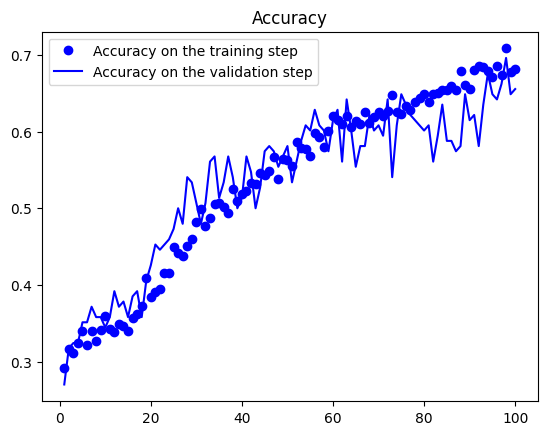

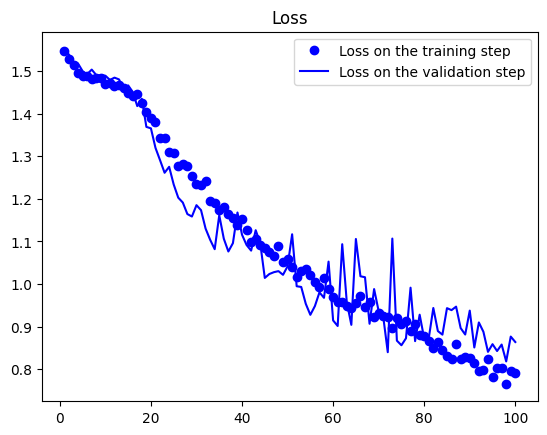

In [16]:
show_plots(history.history)

In [17]:
max(history.history["val_accuracy"])

# To improve the model, we cropped the knee region to focus only on the joint, enhanced the X-ray contrast for clearer visibility, and applied various data augmentations — which helped the model understand the features better.

0.6959459185600281

In [18]:
loaded_model = keras.models.load_model("best_cnn_with_data_augmentation.h5")
loaded_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 256, 256,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 254, 254,  │         80 │ rescaling_2[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 127, 127,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 125, 125,  │      1,168 │ max_pooling2d_6[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 62, 62,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 60, 60,    │      4,640 │ max_pooling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 30, 30,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 28, 28,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 14, 14,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 12, 12,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_20[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 1, 8)   │      1,032 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 1, 128) │      1,152 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 12, 12,    │          0 │ conv2d_20[0][0],  │
│ (Multiply)          │ 128)              │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 18432)     │          0 │ multiply_1[0][0]

 Total params: 192,591 (752.31 KB)

 Trainable params: 192,589 (752.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [19]:
loaded_model.evaluate(test_dataset.batch(32))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6597 - loss: 0.8709


[0.908829391002655, 0.6545454263687134]

#### 4.2. Add fully-connected layers.

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


inputs = keras.Input(shape=(256, 256, 1))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=8, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Add SE attention block to learn channel importance
x = se_block(x, ratio=16)

x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

batched_train_dataset = train_dataset.batch(16)
batched_val_dataset = val_dataset.batch(16)

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = keras.callbacks.ModelCheckpoint(
    "best_cnn_with_data_augmentation_and_dense.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

history = model.fit(
    batched_train_dataset,
    epochs=300,
    validation_data=batched_val_dataset,
    callbacks=callbacks,
)

Epoch 1/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2943 - loss: 1.5755
Epoch 1: val_accuracy improved from -inf to 0.29730, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.2944 - loss: 1.5753 - val_accuracy: 0.2973 - val_loss: 1.5500
Epoch 2/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2844 - loss: 1.5360
Epoch 2: val_accuracy did not improve from 0.29730
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2847 - loss: 1.5358 - val_accuracy: 0.2973 - val_loss: 1.5535
Epoch 3/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2894 - loss: 1.5353
Epoch 3: val_accuracy did not improve from 0.29730
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2896 - loss: 1.5352 - val_accuracy: 0.2973 - val_loss: 1.5487
Epoch 4/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3020 - loss: 1.5303
Epoch 4: val_accuracy improved from 0.29730 to 0.35135, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3026 - loss: 1.5296 - val_accuracy: 0.3514 - val_loss: 1.5229
Epoch 5/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2866 - loss: 1.5107
Epoch 5: val_accuracy did not improve from 0.35135
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2870 - loss: 1.5106 - val_accuracy: 0.3514 - val_loss: 1.5147
Epoch 6/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3182 - loss: 1.5062
Epoch 6: val_accuracy did not improve from 0.35135
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3192 - loss: 1.5058 - val_accuracy: 0.3243 - val_loss: 1.5102
Epoch 7/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3012 - loss: 1.5012
Epoch 7: val_accuracy did not improve from 0.35135
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3020 - loss: 1.5010 - val_accuracy: 0.3446 - val_loss: 1.4951
Epoch 8/300
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2993 - loss: 1.4934
Epoch 8: val_accuracy did not improve f

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3288 - loss: 1.4810 - val_accuracy: 0.3649 - val_loss: 1.4857
Epoch 10/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3164 - loss: 1.4786
Epoch 10: val_accuracy did not improve from 0.36486
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3175 - loss: 1.4784 - val_accuracy: 0.3649 - val_loss: 1.4958
Epoch 11/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3252 - loss: 1.4745
Epoch 11: val_accuracy improved from 0.36486 to 0.37162, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3255 - loss: 1.4744 - val_accuracy: 0.3716 - val_loss: 1.4874
Epoch 12/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3438 - loss: 1.4843
Epoch 12: val_accuracy did not improve from 0.37162
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3440 - loss: 1.4842 - val_accuracy: 0.3649 - val_loss: 1.4734
Epoch 13/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3384 - loss: 1.4692
Epoch 13: val_accuracy did not improve from 0.37162
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3387 - loss: 1.4691 - val_accuracy: 0.3649 - val_loss: 1.4481
Epoch 14/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3558 - loss: 1.4617
Epoch 14: val_accuracy improved from 0.37162 to 0.44595, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3559 - loss: 1.4615 - val_accuracy: 0.4459 - val_loss: 1.3876
Epoch 15/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3582 - loss: 1.4366
Epoch 15: val_accuracy improved from 0.44595 to 0.47973, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3585 - loss: 1.4365 - val_accuracy: 0.4797 - val_loss: 1.3440
Epoch 16/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3851 - loss: 1.4066
Epoch 16: val_accuracy improved from 0.47973 to 0.50676, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3857 - loss: 1.4058 - val_accuracy: 0.5068 - val_loss: 1.2741
Epoch 17/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3949 - loss: 1.3490
Epoch 17: val_accuracy did not improve from 0.50676
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3949 - loss: 1.3490 - val_accuracy: 0.4932 - val_loss: 1.2387
Epoch 18/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4130 - loss: 1.3316
Epoch 18: val_accuracy did not improve from 0.50676
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4129 - loss: 1.3315 - val_accuracy: 0.4932 - val_loss: 1.2143
Epoch 19/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4326 - loss: 1.2919
Epoch 19: val_accuracy did not improve from 0.50676
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4328 - loss: 1.2916 - val_accuracy: 0.5068 - val_loss: 1.2203
Epoch 20/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4647 - loss: 1.2655
Epoch 20: val_accuracy improved 

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4647 - loss: 1.2655 - val_accuracy: 0.5811 - val_loss: 1.1100
Epoch 21/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4347 - loss: 1.2460
Epoch 21: val_accuracy did not improve from 0.58108
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4349 - loss: 1.2460 - val_accuracy: 0.4730 - val_loss: 1.2397
Epoch 22/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4772 - loss: 1.2145
Epoch 22: val_accuracy did not improve from 0.58108
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4773 - loss: 1.2144 - val_accuracy: 0.5405 - val_loss: 1.1575
Epoch 23/300
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4802 - loss: 1.1896
Epoch 23: val_accuracy improved from 0.58108 to 0.58784, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4807 - loss: 1.1900 - val_accuracy: 0.5878 - val_loss: 1.0481
Epoch 24/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5125 - loss: 1.1565
Epoch 24: val_accuracy did not improve from 0.58784
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5125 - loss: 1.1568 - val_accuracy: 0.5405 - val_loss: 1.0540
Epoch 25/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5169 - loss: 1.1418
Epoch 25: val_accuracy did not improve from 0.58784
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5167 - loss: 1.1420 - val_accuracy: 0.5135 - val_loss: 1.1675
Epoch 26/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5213 - loss: 1.1439
Epoch 26: val_accuracy did not improve from 0.58784
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5215 - loss: 1.1448 - val_accuracy: 0.4797 - val_loss: 1.1648
Epoch 27/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5139 - loss: 1.1084
Epoch 27: val_accuracy improved 

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5139 - loss: 1.1085 - val_accuracy: 0.5946 - val_loss: 1.0142
Epoch 28/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5121 - loss: 1.1068
Epoch 28: val_accuracy did not improve from 0.59459
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5123 - loss: 1.1068 - val_accuracy: 0.5068 - val_loss: 1.1487
Epoch 29/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5592 - loss: 1.1023
Epoch 29: val_accuracy did not improve from 0.59459
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5586 - loss: 1.1027 - val_accuracy: 0.5473 - val_loss: 1.0266
Epoch 30/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5458 - loss: 1.0671
Epoch 30: val_accuracy did not improve from 0.59459
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5460 - loss: 1.0676 - val_accuracy: 0.5270 - val_loss: 1.0970
Epoch 31/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5235 - loss: 1.0813
Epoch 31: val_accuracy did not i

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5777 - loss: 1.0012 - val_accuracy: 0.6216 - val_loss: 0.9295
Epoch 37/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5581 - loss: 1.0443
Epoch 37: val_accuracy did not improve from 0.62162
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5582 - loss: 1.0440 - val_accuracy: 0.6216 - val_loss: 0.8927
Epoch 38/300
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5655 - loss: 1.0432
Epoch 38: val_accuracy did not improve from 0.62162
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5659 - loss: 1.0423 - val_accuracy: 0.5878 - val_loss: 0.9588
Epoch 39/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6089 - loss: 0.9574
Epoch 39: val_accuracy did not improve from 0.62162
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6090 - loss: 0.9576 - val_accuracy: 0.5541 - val_loss: 1.0518
Epoch 40/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5848 - loss: 1.0062
Epoch 40: val_accuracy did not i

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6161 - loss: 0.9639 - val_accuracy: 0.6486 - val_loss: 0.9463
Epoch 44/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6082 - loss: 0.9467
Epoch 44: val_accuracy did not improve from 0.64865
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6089 - loss: 0.9455 - val_accuracy: 0.5811 - val_loss: 1.0686
Epoch 45/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6070 - loss: 0.9266
Epoch 45: val_accuracy improved from 0.64865 to 0.66216, saving model to best_cnn_with_data_augmentation_and_dense.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6076 - loss: 0.9260 - val_accuracy: 0.6622 - val_loss: 0.8374
Epoch 46/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6347 - loss: 0.8991
Epoch 46: val_accuracy did not improve from 0.66216
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6344 - loss: 0.8994 - val_accuracy: 0.6486 - val_loss: 0.8295
Epoch 47/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6361 - loss: 0.9000
Epoch 47: val_accuracy did not improve from 0.66216
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6360 - loss: 0.9003 - val_accuracy: 0.6216 - val_loss: 0.8718
Epoch 48/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6376 - loss: 0.8808
Epoch 48: val_accuracy did not improve from 0.66216
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6376 - loss: 0.8810 - val_accuracy: 0.6081 - val_loss: 0.9335
Epoch 49/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6411 - loss: 0.8869
Epoch 49: val_accuracy did not i

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6590 - loss: 0.8281 - val_accuracy: 0.6689 - val_loss: 0.8589
Epoch 53/300
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6887 - loss: 0.8214
Epoch 53: val_accuracy did not improve from 0.66892
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6881 - loss: 0.8224 - val_accuracy: 0.6014 - val_loss: 0.9258
Epoch 54/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6491 - loss: 0.8753
Epoch 54: val_accuracy did not improve from 0.66892
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6493 - loss: 0.8750 - val_accuracy: 0.6689 - val_loss: 0.9271
Epoch 55/300
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6654 - loss: 0.8543
Epoch 55: val_accuracy did not improve from 0.66892
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6653 - loss: 0.8538 - val_accuracy: 0.6622 - val_loss: 0.8601
Epoch 56/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6535 - loss: 0.8438
Epoch 56: val_accuracy improved 

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6533 - loss: 0.8439 - val_accuracy: 0.6959 - val_loss: 0.8517
Epoch 57/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6772 - loss: 0.8079
Epoch 57: val_accuracy did not improve from 0.69595
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6769 - loss: 0.8093 - val_accuracy: 0.6622 - val_loss: 0.8472
Epoch 58/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6857 - loss: 0.7926
Epoch 58: val_accuracy did not improve from 0.69595
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6855 - loss: 0.7928 - val_accuracy: 0.6622 - val_loss: 0.8390
Epoch 59/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6874 - loss: 0.7926
Epoch 59: val_accuracy did not improve from 0.69595
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6872 - loss: 0.7930 - val_accuracy: 0.6554 - val_loss: 0.8132
Epoch 60/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6889 - loss: 0.7934
Epoch 60: val_accuracy did not i

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6943 - loss: 0.7290 - val_accuracy: 0.7162 - val_loss: 0.7222
Epoch 63/300
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6794 - loss: 0.7804
Epoch 63: val_accuracy did not improve from 0.71622
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6793 - loss: 0.7811 - val_accuracy: 0.6892 - val_loss: 0.7666
Epoch 64/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7260 - loss: 0.7543
Epoch 64: val_accuracy did not improve from 0.71622
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7258 - loss: 0.7545 - val_accuracy: 0.6892 - val_loss: 0.7681
Epoch 65/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7257 - loss: 0.7321
Epoch 65: val_accuracy did not improve from 0.71622
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7253 - loss: 0.7325 - val_accuracy: 0.6486 - val_loss: 0.8709
Epoch 66/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7045 - loss: 0.7290
Epoch 66: val_accuracy did not i

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7211 - loss: 0.7005 - val_accuracy: 0.7635 - val_loss: 0.6776
Epoch 70/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7163 - loss: 0.6855
Epoch 70: val_accuracy did not improve from 0.76351
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7164 - loss: 0.6862 - val_accuracy: 0.6824 - val_loss: 0.8494
Epoch 71/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7165 - loss: 0.7107
Epoch 71: val_accuracy did not improve from 0.76351
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7168 - loss: 0.7108 - val_accuracy: 0.7095 - val_loss: 0.7658
Epoch 72/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7118 - loss: 0.7710
Epoch 72: val_accuracy did not improve from 0.76351
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7117 - loss: 0.7709 - val_accuracy: 0.6622 - val_loss: 0.7910
Epoch 73/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7150 - loss: 0.7228
Epoch 73: val_accuracy did not i

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7900 - loss: 0.5737 - val_accuracy: 0.7973 - val_loss: 0.6909
Epoch 111/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7947 - loss: 0.5686
Epoch 111: val_accuracy did not improve from 0.79730
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7947 - loss: 0.5682 - val_accuracy: 0.7432 - val_loss: 0.8029
Epoch 112/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8164 - loss: 0.4960
Epoch 112: val_accuracy did not improve from 0.79730
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8160 - loss: 0.4981 - val_accuracy: 0.6959 - val_loss: 0.8892
Epoch 113/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8152 - loss: 0.4934
Epoch 113: val_accuracy did not improve from 0.79730
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8151 - loss: 0.4937 - val_accuracy: 0.7230 - val_loss: 0.9637
Epoch 114/300
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7976 - loss: 0.5585
Epoch 114: val_accuracy d

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8919 - loss: 0.3324 - val_accuracy: 0.8108 - val_loss: 0.9118
Epoch 288/300
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8909 - loss: 0.3423
Epoch 288: val_accuracy did not improve from 0.81081
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8905 - loss: 0.3424 - val_accuracy: 0.7703 - val_loss: 0.9848
Epoch 289/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8971 - loss: 0.3137
Epoch 289: val_accuracy did not improve from 0.81081
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8970 - loss: 0.3138 - val_accuracy: 0.7568 - val_loss: 0.8079
Epoch 290/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8667 - loss: 0.3454
Epoch 290: val_accuracy did not improve from 0.81081
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8668 - loss: 0.3455 - val_accuracy: 0.7635 - val_loss: 0.8069
Epoch 291/300
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8798 - loss: 0.3473
Epoch 291: val_accuracy d

In [26]:
max(history.history["val_accuracy"])

0.8108108043670654

In [22]:
loaded_model = keras.models.load_model("best_cnn_with_data_augmentation_and_dense.h5")
loaded_model.evaluate(test_dataset.batch(32))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6995 - loss: 1.3460


[1.187597393989563, 0.6969696879386902]

In [23]:
loaded_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 256, 256,  │          0 │ input_layer_4[0]… │
│ (Sequential)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 256, 256,  │          0 │ sequential_1[0][… │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 254, 254,  │         80 │ rescaling_3[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 127, 127,  │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 125, 125,  │      1,168 │ max_pooling2d_10… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 62, 62,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 60, 60,    │      4,640 │ max_pooling2d_11… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 30, 30,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 28, 28,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 14, 14,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 12, 12,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 6, 6, 128) │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_14… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1, 1, 8)   │      1,032 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1, 1, 128) │      1,152 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 6, 6, 128) │          0 │ max_pooling2d_14

 Total params: 5,347,407 (20.40 MB)

 Trainable params: 5,347,405 (20.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

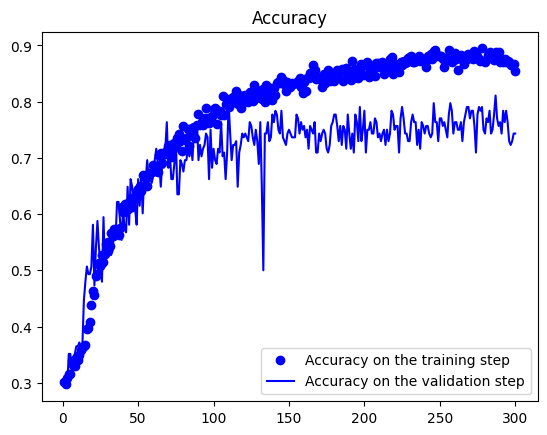

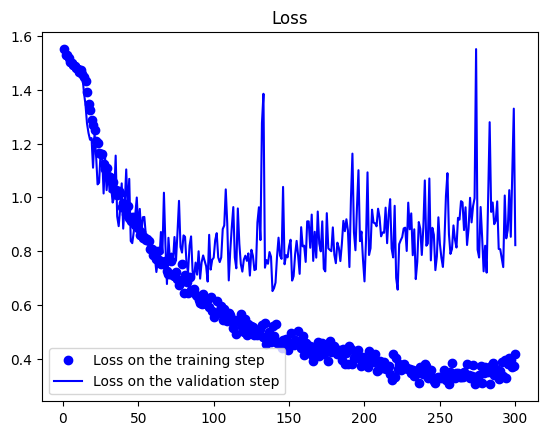

In [24]:
show_plots(history.history)

In [27]:
# Evaluate on test dataset
test_loss, test_acc = loaded_model.evaluate(test_dataset.batch(32), verbose=0)

# Extract training and validation accuracy history
train_acc_final = history.history['accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])

# Print final results
print(f"✅ Final Training Accuracy    : {train_acc_final * 100:.2f}%")
print(f"✅ Best Validation Accuracy   : {best_val_acc * 100:.2f}%")

✅ Final Training Accuracy    : 85.49%
✅ Best Validation Accuracy   : 81.08%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Actual Label: 1 | Predicted Label: 0


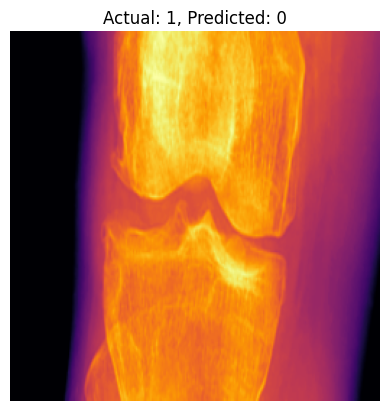

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Actual Label: 0 | Predicted Label: 0


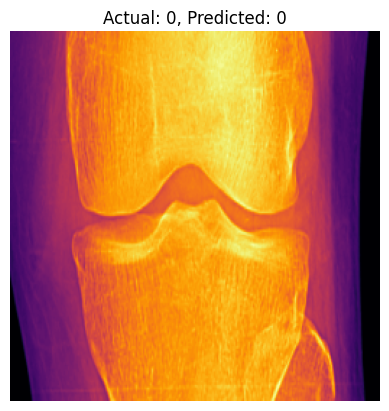

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Actual Label: 1 | Predicted Label: 1


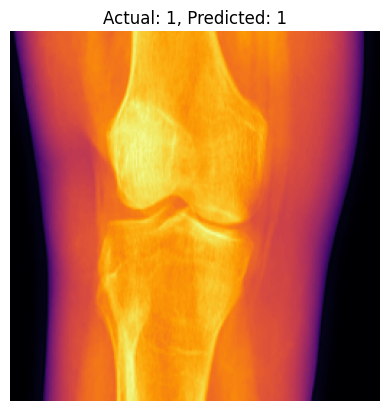

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Actual Label: 1 | Predicted Label: 1


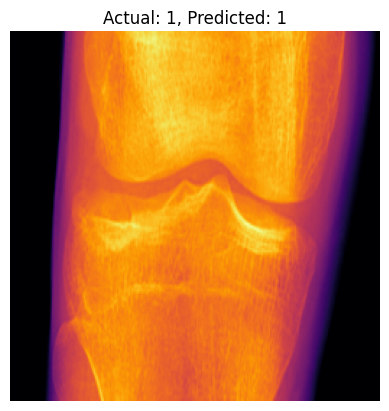

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Actual Label: 2 | Predicted Label: 2


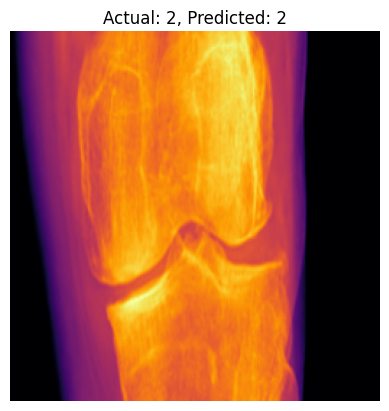


✅ Matched: 4/5
📊 Accuracy: 80.00%


In [32]:
correct_predictions = 0
total_predictions = 5

# Shuffle and take 5 random samples
for image, label in test_dataset.shuffle(1000).take(total_predictions):
    # Expand dimensions to make it a batch of one image
    img = np.expand_dims(image.numpy(), axis=0)

    # Predict using the loaded model
    prediction = loaded_model.predict(img)
    predicted_label = np.argmax(prediction)

    # Actual label
    actual_label = label.numpy().astype("uint8")

    # Check if prediction is correct
    if predicted_label == actual_label:
        correct_predictions += 1

    # Print and show image
    print(f"Actual Label: {actual_label} | Predicted Label: {predicted_label}")
    plt.imshow(image.numpy().astype("uint8").squeeze(), cmap="inferno")
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

# 🔢 Accuracy
accuracy = (correct_predictions / total_predictions) * 100
print(f"\n✅ Matched: {correct_predictions}/{total_predictions}")
print(f"📊 Accuracy: {accuracy:.2f}%")